# Assembly of system with multiple domains, variables and numerics

This tutorial demonstrate how a transient problem may be solved in PorePy. We consider the purely advective tracer transport problem for a static flow field, see the tutorial darcy_and_transport_equations.ipynb. The geometry and flow parameters are as in example 2 of this [benchmark study](https://www.sciencedirect.com/science/article/pii/S0309170817300143).


In [1]:
import numpy as np
import scipy.sparse as sps

import porepy as pp
from examples.example1.benchmark1.test_vem import make_grid_bucket
from examples.example1.benchmark1.test_fv import add_data as add_flow_data

In [2]:
def add_transport_data(gb, parameter_keyword):
    # Method to assign data.
    tol = 1e-4
    for g, d in gb:
        # Boundary conditions: Dirichlet for left and right side of the domain
        b_faces = g.tags["domain_boundary_faces"].nonzero()[0]
        bc_val = np.zeros(g.num_faces)
        
        unity = np.ones(g.num_cells)
        empty = np.empty(0)
        if b_faces.size != 0:

            b_face_centers = g.face_centers[:, b_faces]
            b_inflow = b_face_centers[0, :] < tol
            b_outflow = b_face_centers[0, :] > 1-tol

            

            labels = np.array(["neu"] * b_faces.size)
            labels[np.logical_or(b_inflow, b_outflow)] = "dir"
            bc = pp.BoundaryCondition(g, b_faces, labels)

            bc_val[b_faces[b_inflow]] = 1

        else:
            bc = pp.BoundaryCondition(g) #, empty, empty)
        
        # Porosity
        if g.dim == gb.dim_max():
            porosity = 0.2 * unity
        else:
            porosity = 0.8 * unity
        
        # Inherit the aperture assigned for the flow problem
        specified_parameters = {
            "aperture": d[pp.PARAMETERS]["flow"]["aperture"],
            "bc": bc,
            "bc_values": bc_val,
            "time_step": 1 / 60,
            "mass_weight": porosity,
            "t_max": 1 / 3,
            }
        pp.initialize_default_data(g, d, parameter_keyword, specified_parameters)
        
        # Store the dimension in the dictionary for visualization purposes
        d["dimension"] = g.dim * np.ones(g.num_cells)
        
    for e, d in gb.edges():
        d[pp.PARAMETERS].update_dictionaries(parameter_keyword, {})
        d[pp.DISCRETIZATION_MATRICES][parameter_keyword] = {}
    return gb

We start by making a grid bucket, pecifying the keywords for the parameters of the flow and transport problem, respectively. Then we assigne the problem data and visualize the domain.

/home/eke001/Dropbox/workspace/python/ppdir/src/porepy/utils/comp_geom.py:1168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_pt = np.hstack((p, np.vstack((i for i in new_pts)).T))


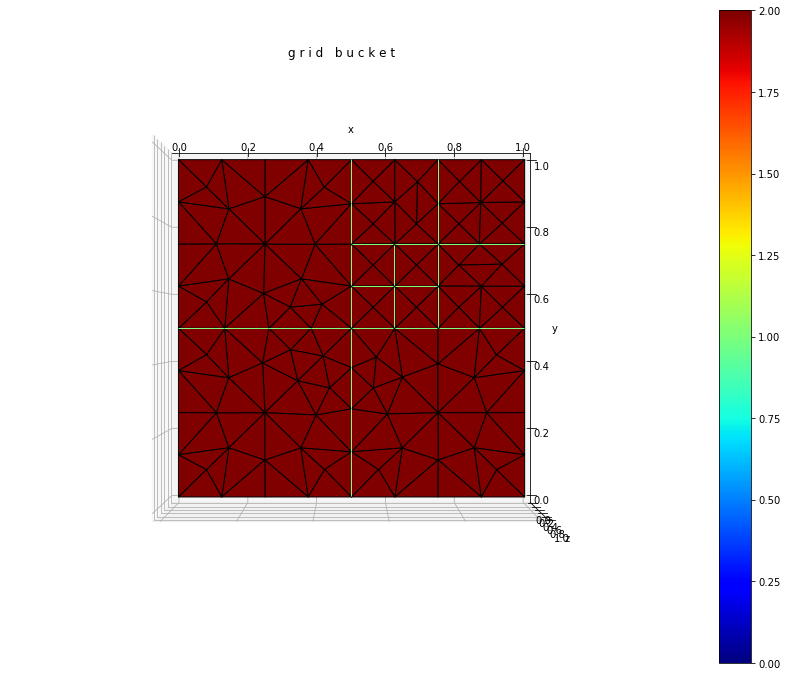

In [3]:
mesh_size = 0.15
gb, domain = make_grid_bucket(mesh_size)
fracture_permeability = 1e4
kw_f = 'flow'
kw_t = 'transport'
add_flow_data(gb, domain, fracture_permeability, mesh_size)
gb = add_transport_data(gb, kw_t)
pp.plot_grid(gb, "dimension", figsize=(15, 12))

Now, we define the variables on grids and edges and identify the individual terms of the equation we want to solve. We have an equation for the pressure on each grid (node of the GridBucket), and an equation for the mortar flux between them (edge of the bucket). The terms to be discretized are the diffusion term on the nodes ($- \nabla \cdot K \nabla p$) and the coupling term $- \kappa (p_{fracture} - \texttt{tr }p_{matrix})$ on the edges. See parameter_assignment_assembler_setup.ipynb for more detail on how to set up the flow problem.

In [4]:
grid_variable = 'pressure'
mortar_variable = 'mortar_flux'

operator_keyword = 'diffusion'
coupling_operator_keyword = 'coupling_operator'

tpfa = pp.Tpfa(kw_f)

edge_discretization = pp.RobinCoupling(kw_f, tpfa, tpfa)

# Loop over the nodes in the GridBucket, define primary variables and discretization schemes
for g, d in gb:
    d[pp.PRIMARY_VARIABLES] = {grid_variable: {"cells": 1, "faces": 0}}
    d[pp.DISCRETIZATION] = {grid_variable: {operator_keyword: tpfa}}
    
# Loop over the edges in the GridBucket, define primary variables and discretizations
for e, d in gb.edges():
    g1, g2 = gb.nodes_of_edge(e)
    d[pp.PRIMARY_VARIABLES] = {mortar_variable: {"cells": 1}}
    d[pp.COUPLING_DISCRETIZATION] = {
        coupling_operator_keyword: {
            g1: (grid_variable, operator_keyword),
            g2: (grid_variable, operator_keyword),
            e: (mortar_variable, edge_discretization),
        }
    }


Assemble and solve the linear system. Then distribute the pressure variable on the grid bucket, export the solution for visualization and plot directly. Complete the flow part of the simulation by back-computing the fluxes (which are not primary variables in the primal formulation of the finite volume scheme used) from the pressure solution. 

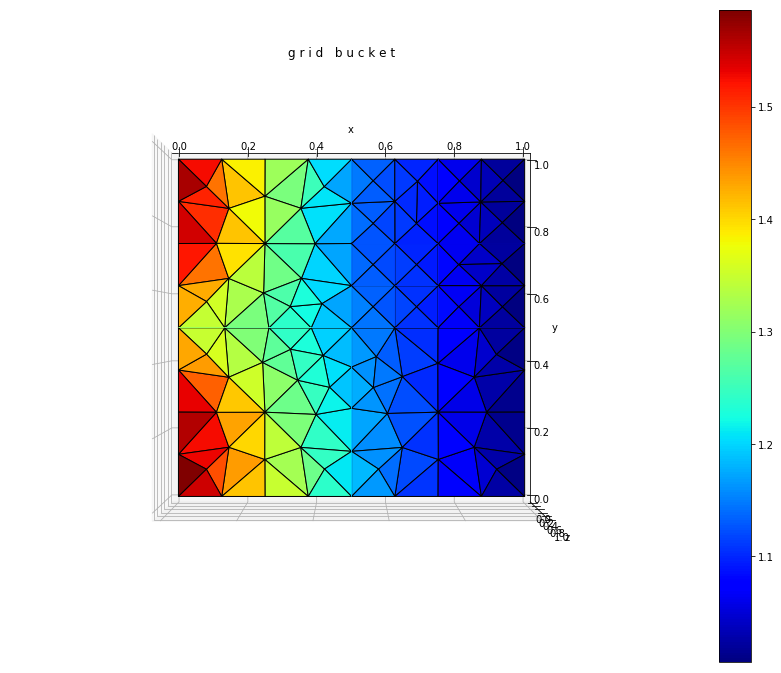

In [5]:
assembler = pp.Assembler(gb)

# Assemble the linear system, using the information stored in the GridBucket
A, b = assembler.assemble_matrix_rhs()

pressure = sps.linalg.spsolve(A, b)

assembler.distribute_variable(pressure)

folder = "tracer_transport"
exporter = pp.Exporter(gb, "flow", folder=folder)
exporter.write_vtk(grid_variable)
pp.plot_grid(gb, grid_variable, figsize=(15, 12))
pp.fvutils.compute_darcy_flux(gb, keyword_store=kw_t ,lam_name=mortar_variable)

Prepare for assembly of the transport problem. The procedure is similar to the one above for the flow problem. Here, the purely advective case is shown, but a diffusive term may easily be added.

In [6]:
grid_variable = "tracer"
mortar_variable = "mortar_tracer"

# Identifier of the discretization operator on each grid
advection_term = "advection"
source_term = "source"
mass_term = "mass"

# Identifier of the discretization operator between grids
advection_coupling_term = "advection_coupling"

# Discretization objects
node_discretization = pp.Upwind(kw_t)
source_discretization = pp.ScalarSource(kw_t)
mass_discretization = pp.MassMatrix(kw_t)
edge_discretization = pp.UpwindCoupling(kw_t)

# Loop over the nodes in the GridBucket, define primary variables and discretization schemes
for g, d in gb:
    # Assign primary variables on this grid. It has one degree of freedom per cell.
    d[pp.PRIMARY_VARIABLES] = {grid_variable: {"cells": 1, "faces": 0}}
    # Assign discretization operator for the variable.
    d[pp.DISCRETIZATION] = {
        grid_variable: {
            advection_term: node_discretization,
            source_term: source_discretization,
            mass_term: mass_discretization,
        }
    }
    if g.dim == 2:
        data = d[pp.PARAMETERS][kw_t]

# Loop over the edges in the GridBucket, define primary variables and discretizations
for e, d in gb.edges():
    g1, g2 = gb.nodes_of_edge(e)
    # The mortar variable has one degree of freedom per cell in the mortar grid
    d[pp.PRIMARY_VARIABLES] = {mortar_variable: {"cells": 1}}

    d[pp.COUPLING_DISCRETIZATION] = {
        advection_coupling_term: {
            g1: (grid_variable, advection_term),
            g2: (grid_variable, advection_term),
            e: (mortar_variable, edge_discretization),
        }
    }

Assemble the linear system, using the information stored in the GridBucket. By not adding the matrices, we can arrange them at will to obtain the efficient solver defined below, which LU factorizes the system only once for all time steps.

In [7]:
assembler = pp.Assembler(gb, active_variables=[grid_variable, mortar_variable])


A, b = assembler.assemble_matrix_rhs(
    add_matrices=False
)

advection_coupling_term += (
    "_" + mortar_variable + "_" + grid_variable + "_" + grid_variable
)
mass_term += "_" + grid_variable
advection_term += "_" + grid_variable
source_term += "_" + grid_variable

lhs = A[mass_term] + data["time_step"] * (
    A[advection_term] + A[advection_coupling_term]
)
rhs_source_adv = b[source_term] + data["time_step"] * (
    b[advection_term] + b[advection_coupling_term]
)

IEsolver = sps.linalg.factorized(lhs)

/home/eke001/anaconda3/envs/pp/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Prepare for solving the transient problem and exporting the solution.

In [8]:
save_every = 1
n_steps = int(np.round(data["t_max"] / data["time_step"]))

# Initial condition
tracer = np.zeros(rhs_source_adv.size)
assembler.distribute_variable(
    tracer, variable_names=[grid_variable, mortar_variable]
)

# Exporter
exporter = pp.Exporter(gb, name="tracer", folder=folder)
export_fields = ["tracer"]

Solve the tracer transport problem in a time loop, exporting for some of the steps.

In [9]:
for i in range(n_steps):
    
    if np.isclose(i % save_every, 0):
        # Export existing solution (final export is taken care of below)
        assembler.distribute_variable(
        tracer,
        variable_names=[grid_variable, mortar_variable],
    )
        exporter.write_vtk(export_fields, time_step=int(i // save_every))
    tracer = IEsolver(A[mass_term] * tracer + rhs_source_adv)

    
    

exporter.write_vtk(export_fields, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, data["t_max"] + data["time_step"], save_every * data["time_step"]
)
exporter.write_pvd(time_steps)

We plot the final tracer distribution. The tracer enters from the right boundary, and is transported more quickly through the fractures than the matrix.

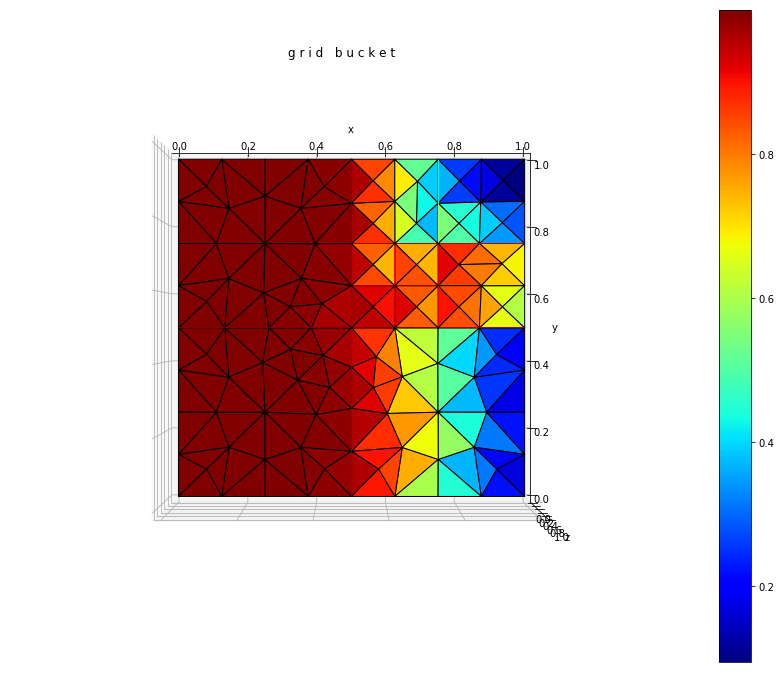

In [10]:
pp.plot_grid(gb, grid_variable, figsize=(15, 12))

In [11]:
g = gb.grids_of_dimension(2)[0]
data = gb.node_props(g)
assert np.allclose(data['tracer'][-1], 0.99089862)